In [71]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os

In [72]:
import sys
sys.path.append("../")
import PF
import ROI
importlib.reload(PF)
importlib.reload(ROI)

<module 'ROI' from '..\\ROI.py'>

In [73]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(spectrum,source_energies,source_isotopes):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)
        #plt.savefig('isotope %s.png'%isotope,dpi = 200)
        
def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spec.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spec.livetime)
    return eff, eff_uncer

In [74]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)
        
        


In [75]:
path = r'C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis'
spec = path + r'\NAA_eff_calibration.Spe'
bg = path + r'\background-long.Spe'
ecal = path + r'\E-calibration-Eu152.Spe'

spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)
ecal = bq.Spectrum.from_file(ecal)

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\NAA_eff_calibration.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\background-long.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\E-calibration-Eu152.Spe


In [76]:
spec.calibrate_like(ecal)
bg.calibrate_like(ecal)

In [77]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                            'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([88.34,201.83,306.78,
                           788.742,1435.795,
                           1460.83]);
source_activities = np.array([16.259,16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L
branching_ratio = np.array([0.11,0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''

'The real source energies:\nLu-176: 88.34, 201.83, 306.78\nLa-138: 788.742,1435.795\nK-40: 1460.83'

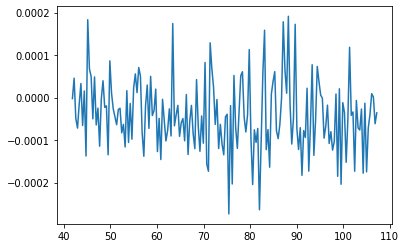

In [78]:
spec_sub = spec-bg
#spec_sub.plot()
plt.plot(spec.bin_centers_kev[70:250],spec_sub.cps_vals[70:250])

In [47]:
roi = ROI.ROI(spec, bg, [source_energies[0]], sub_type = 0)
delta_e0 = 8
window0 = np.array([[-3.3, -2.6], [-0.5, 0.5], [1.2, 3.5]])
roi.set_sideband(delta_e0,window0)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result0,roi_uncer0 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result0)
print('uncertainties:',roi_uncer0)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 21157.256512798904
bg peak counts 20436.88515569021
signal bg 20512.5
signal peak 20168.0
[92.0]
ROI result: [375.8713571086955]
uncertainties: [247.870456916692]


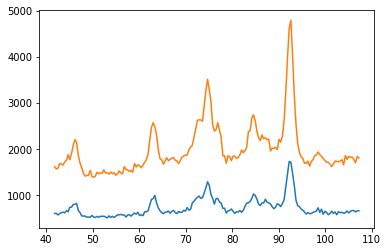

In [44]:
#spec.plot(yscale="log")
#np.where(spec.bin_centers_kev>74.9)
plt.plot(spec.bin_centers_kev[70:250],spec.counts_vals[70:250])
plt.plot(bg.bin_centers_kev[70:250],bg.counts_vals[70:250])

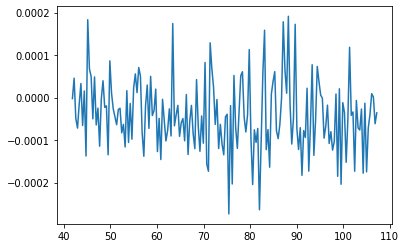

In [45]:
plt.plot(spec.bin_centers_kev[70:250],spec.counts_vals[70:250]/spec.livetime - bg.counts_vals[70:250]/bg.livetime)

[92.0]


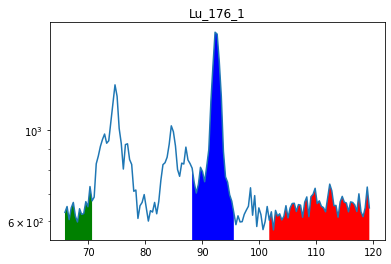

In [48]:
plot_peak_region(spec,[source_energies[0]],[source_isotopes[0]])

In [53]:
roi = ROI.ROI(spec, bg, [source_energies[1]], sub_type = 0)
delta_e = 6
window = np.array([[-2.5, -1.5], [-0.5, 0.4], [1.5, 2.5]])
roi.set_sideband(delta_e,window)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result1,roi_uncer1 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result1)
print('uncertainties:',roi_uncer1)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 8144.420677825368
bg peak counts 7050.743988151436
signal bg 7811.5
signal peak 8806.0
[202.0]
ROI result: [2088.1766896739327]
uncertainties: [154.38492260277272]


[202.0]


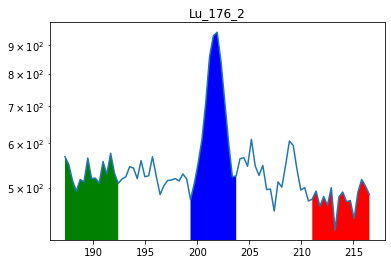

In [54]:
plot_peak_region(spec,[source_energies[1]],[source_isotopes[1]])

In [55]:
roi = ROI.ROI(spec, bg, [source_energies[2]], sub_type = 0)
delta_e2 = 8
window2 = np.array([[-3, -2], [-0.5, 0.4], [2, 3]])
roi.set_sideband(delta_e2,window2)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result2,roi_uncer2 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result2)
print('uncertainties:',roi_uncer2)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 7164.447656245833
bg peak counts 6183.171973984364
signal bg 6797.0
signal peak 7761.0
[307.0]
ROI result: [1945.2756822614692]
uncertainties: [144.65440125384114]


[307.0]


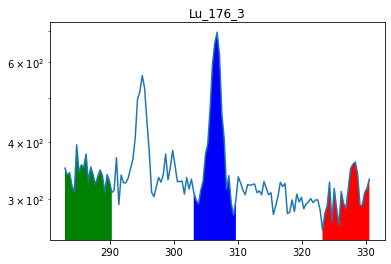

In [56]:
plot_peak_region(spec,[source_energies[2]],[source_isotopes[2]])

In [57]:
roi = ROI.ROI(spec, bg, [source_energies[3]], sub_type = 0)
delta_e3 = 8
window3 = np.array([[-5, -3], [-0.8, 0.2], [3, 5]])
roi.set_sideband(delta_e3,window3)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result3,roi_uncer3 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result3)
print('uncertainties:',roi_uncer3)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 4659.43116488956
bg peak counts 2333.251375724311
signal bg 4144.0
signal peak 2384.0
[789.0]
ROI result: [566.1797891652491]
uncertainties: [95.4932822672312]


[789.0]


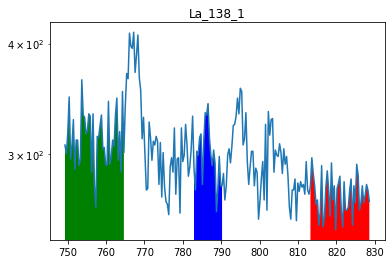

In [58]:
plot_peak_region(bg,[source_energies[3]],[source_isotopes[3]])

In [83]:
roi = ROI.ROI(spec, bg, [source_energies[4]], sub_type = 0)
delta_e4 = 8
window4 = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e4,window4)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result4,roi_uncer4 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result4)
print('uncertainties:',roi_uncer4)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 738.4225122726166
bg peak counts 775.6413888992606
signal bg 745.0
signal peak 1138.0000000000002
[1436.0]
ROI result: [355.7811233733562]
uncertainties: [51.53011396295926]


[1436.0]


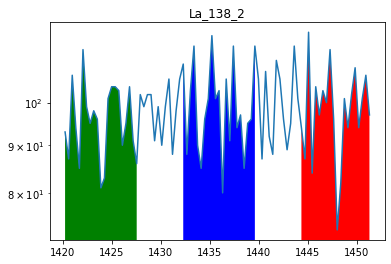

In [84]:
plot_peak_region(bg,[source_energies[4]],[source_isotopes[4]])

In [61]:
roi = ROI.ROI(spec, bg, [source_energies[5]], sub_type = 0)
delta_e5 = 8
window5 = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e5,window5)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result5,roi_uncer5 = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result5)
print('uncertainties:',roi_uncer5)
#print('Lu_176 PF result:',pf_result)

background spec sidebands 700.645352496573
bg peak counts 4448.400134416488
signal bg 717.0
signal peak 6337.999999999999
[1461.0]
ROI result: [1873.2452180800838]
uncertainties: [107.2157768738574]


[1461.0]


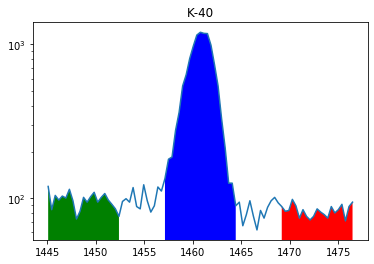

In [62]:
plot_peak_region(bg,[source_energies[5]],[source_isotopes[5]])

In [86]:
roi_result = np.concatenate([roi_result0,roi_result1,roi_result2,roi_result3,roi_result4,roi_result5])
roi_uncer =np.concatenate([roi_uncer0,roi_uncer1,roi_uncer2,roi_uncer3,roi_uncer4,roi_uncer5])

In [87]:
eff,eff_uncer = efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer)
print(eff,eff_uncer)

[0.0005019843866016461, 0.00035670767570141057, 0.0003040163682275899, 0.00034153573682487977, 0.0001105604185875265, 9.578738399317433e-05] [0.0003348208154600936, 4.436111534490968e-05, 3.78859687009076e-05, 5.7608310399325825e-05, 1.601471703914774e-05, 5.485767051114895e-06]


In [88]:
class Efficiency(object):
    """
    Object for undertaking the Efficiency Calibration of a detector.
    Currently only plots the Efficiency versus Energy data and the fitted curve.
    """

    def __init__(self,source_energies,eff,eff_uncer):
        
        self.energy = source_energies
        self.values = eff
        self.unc = eff_uncer
        self.x = []
        self.y = []
        self.space = np.linspace(1, 2160, 540)
        self.z = []
        self.fit = []
        self.new_fit = []

    def mutate(self):
        """
        Mutates data and creates the fit function.
        """
        for i in self.energy: 
            self.x.append(np.log(i/1461))
        for i in self.values:
            self.y.append(np.log(i))
        self.z = np.polyfit(np.asarray(self.x), np.asarray(self.y), 4)

    def normal(self, x): 
        return np.log(x/1461)

    def func3(self, x): 
        return (self.z[0]*self.normal(x)**4)+(self.z[1]*self.normal(x)**3)+(self.z[2]*self.normal(x)**2)+(self.z[3]*self.normal(x))+(self.z[4])

    def new_func(self, x): 
        return np.exp(func3(x))

    def fitting(self):
        """
        Fits the data.
        """
        for i in self.space:
            self.fit.append(self.func3(i))
        for i in self.fit:
            self.new_fit.append(np.exp(i))

    def plotter(self):
        """
        Plots the data and the fit.
        """
        plt.title('Efficiency Curve')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Efficiency')
        plt.errorbar(self.energy, self.values,yerr=self.unc, fmt ='ro',elinewidth=2,capsize=4)
        plt.plot(self.energy, self.values, 'ro')
        plt.grid()
        plt.plot(self.space, self.new_fit)
        plt.legend(('Data Points', 'Fitted Curve'), loc='upper right')
        plt.ylim(0, 0.04)
        plt.savefig('eff_curve.png',dpi=200)
        plt.show()
        
    def main(self):
        self.mutate()
        self.fitting()
        self.plotter()


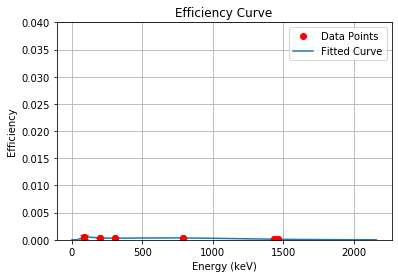

In [89]:
plot_eff = Efficiency(source_energies,eff,eff_uncer)
plot_eff.main()